# Trying qeom with qiskit

## general code

In [19]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
import time

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [20]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

In [21]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

## reference value H2

In [22]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
np_calc = numpy_solver.compute_minimum_eigenvalue(qubit_op)
np_result = es_problem.interpret(np_calc).total_energies[0].real

print(f"Result: {np_result:.5f}")

Result: -1.13731


## vqe H2 in qiskit with VQE

In [23]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
solver = VQE(estimator, ansatz, COBYLA())
solver.initial_point = [0.0] * ansatz.num_parameters

In [24]:
qubit_op = mapper.map(es_problem.second_q_ops()[0])

In [25]:
start = time.time()
vqe_calc = solver.compute_minimum_eigenvalue(qubit_op)
vqe_result = es_problem.interpret(vqe_calc).total_energies[0].real
end = time.time()
print("Time taken [sec]: ", (end-start))
print(f"Result: {vqe_result:.5f}")

Time taken [sec]:  2.1375162601470947
Result: -1.13731


## qiskit 1.0 vqe

In [26]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
import numpy as np

In [27]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session, EstimatorV2 as EstimatorV2

In [28]:
#backend = FakeSherbrooke() # with noise
backend = AerSimulator() # without noise

In [29]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

In [30]:
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

In [31]:
def cost_func(params, ansatz, hamiltonian, estimator, cost_history_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy, result

In [32]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [33]:
initial_point = [0.0]*ansatz.num_parameters

In [34]:
# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

In [35]:
start = time.time()
with Session(backend=backend) as session:
    estimator = EstimatorV2(mode=session)

    res = minimize(
        cost_func_2,
        initial_point,
        args=(ansatz_isa, hamiltonian_isa, estimator, cost_history_dict),
        method="cobyla",
        options={'maxiter': 100})


end = time.time()
print("Time taken [sec]: ", (end-start))

Iters. done: 1 [Current cost: -1.8367029552657999]
Iters. done: 2 [Current cost: -1.2942029325639344]
Iters. done: 3 [Current cost: -1.286012655718318]
Iters. done: 4 [Current cost: -0.5644776654448653]
Iters. done: 5 [Current cost: -1.2270939631455544]
Iters. done: 6 [Current cost: -1.6618983588184273]
Iters. done: 7 [Current cost: -1.814643377190305]
Iters. done: 8 [Current cost: -1.8428644767985871]
Iters. done: 9 [Current cost: -1.6930216156169418]
Iters. done: 10 [Current cost: -1.8472917315567983]
Iters. done: 11 [Current cost: -1.8488668507103068]
Iters. done: 12 [Current cost: -1.8052448841942437]
Iters. done: 13 [Current cost: -1.8477021248411845]
Iters. done: 14 [Current cost: -1.8407496739630336]
Iters. done: 15 [Current cost: -1.8370902831007596]
Iters. done: 16 [Current cost: -1.842440326531553]
Iters. done: 17 [Current cost: -1.8409796195700892]
Iters. done: 18 [Current cost: -1.8389915264986618]
Iters. done: 19 [Current cost: -1.8373877236036662]
Iters. done: 20 [Current

In [36]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.844906302843576
       x: [-1.090e-01  8.873e-02 -1.332e-01]
    nfev: 33
   maxcv: 0.0

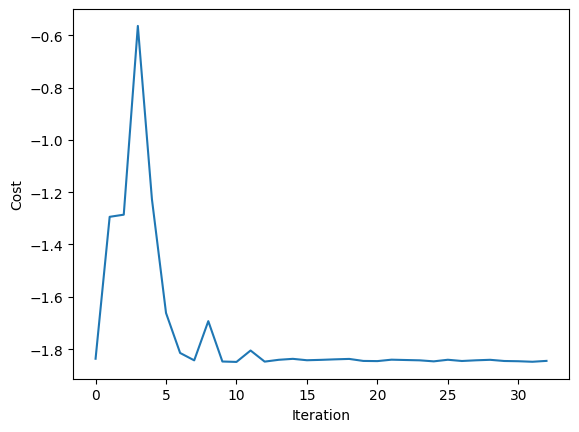

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.draw()

In [42]:
# now run ansatz with optimized parameters
opt_params = res.x

with Session(backend=backend) as session:
    estimator = EstimatorV2(mode=session)

    pub = (ansatz_isa, [hamiltonian_isa], [opt_params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    print(f"Resulting optimized energy {energy:.5f}")

Resulting optimized energy -1.83981
